In [1]:
# import sys
# !{sys.executable} -m pip install -U bambi pymc arviz

In [1]:
import sys
!{sys.executable} -m pip uninstall -y unwrap
!{sys.executable} -m pip install -U --no-cache git+https://github.com/jgraving/unwrap

Found existing installation: unwrap 0.0.1
Uninstalling unwrap-0.0.1:
  Successfully uninstalled unwrap-0.0.1
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Cloning https://github.com/jgraving/unwrap to /private/var/folders/nq/smdrxv810_z_tfcmgmg5gkb00000gn/T/pip-req-build-aqft242w
  Running command git clone --filter=blob:none --quiet https://github.com/jgraving/unwrap /private/var/folders/nq/smdrxv810_z_tfcmgmg5gkb00000gn/T/pip-req-build-aqft242w
  Resolved https://github.com/jgraving/unwrap to commit b158ec9cf3b6d06ed4c9baa721978c7a1ab1dd84
  Preparing metadata (setup.py) ... done
  Created wheel for unwrap: filename=unwrap-0.0.1-py3-none-any.whl size=11562 sha256=de770369b94bf801bc0c0bb66e9f8aa06e7ecc216a4e37d87887c15d6fd3e812
  Stored in directory: /private/var/folders/n

In [2]:
import numpy as np
import bambi as bmb
import arviz as az
import pymc as pm
import pytensor.tensor as pt
import matplotlib.pyplot as plt

from scipy.stats import vonmises, circmean

from unwrap.link.bambi import LINKS
from unwrap.prior import CircularUniformPrior
from unwrap.data import generate_circular_regression_data

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

data = generate_circular_regression_data(
    num_samples=1000,
    x_range=(-1, 1),
    mean_intercept=np.pi,
    mean_slope=np.pi,
    conc_intercept=2,
    conc_slope=1,
    mean_link="shifted_modulo",
    conc_link="softplus",
)

formula = bmb.Formula("y ~ x", "kappa ~ x")
model = bmb.Model(
    formula,
    data,
    family="vonmises",
    priors={
        "Intercept": CircularUniformPrior(),
        "x": bmb.Prior("Normal", mu=0, sigma=0.5 * np.pi),
        "kappa": {
            "Intercept": bmb.Prior("Normal", mu=2, sigma=0.5),
            "x": bmb.Prior("Normal", mu=1, sigma=1.0),
        },
    },
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
)
print(model)

idata = model.fit(draws=1000)

Sampling: [x, y]


       Formula: y ~ x
                kappa ~ x
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 1000
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ CircularUniform()
            x ~ Normal(mu: 0.0, sigma: 1.5708)
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 2.0, sigma: 0.5)
            kappa_x ~ Normal(mu: 1.0, sigma: 1.0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, x, kappa_Intercept, kappa_x]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


In [3]:
az.summary(idata, var_names=["Intercept", "x", "kappa_Intercept", "kappa_x"], circ_var_names=["Intercept"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-3.132,0.027,3.100,-3.080,0.000,0.041,3361.0,3434.0,1.0
x,3.142,0.043,3.061,3.221,0.001,0.000,5263.0,3576.0,1.0
kappa_Intercept,1.917,0.091,1.746,2.088,0.001,0.001,5677.0,2918.0,1.0
kappa_x,0.581,0.156,0.282,0.875,0.002,0.001,6051.0,3245.0,1.0


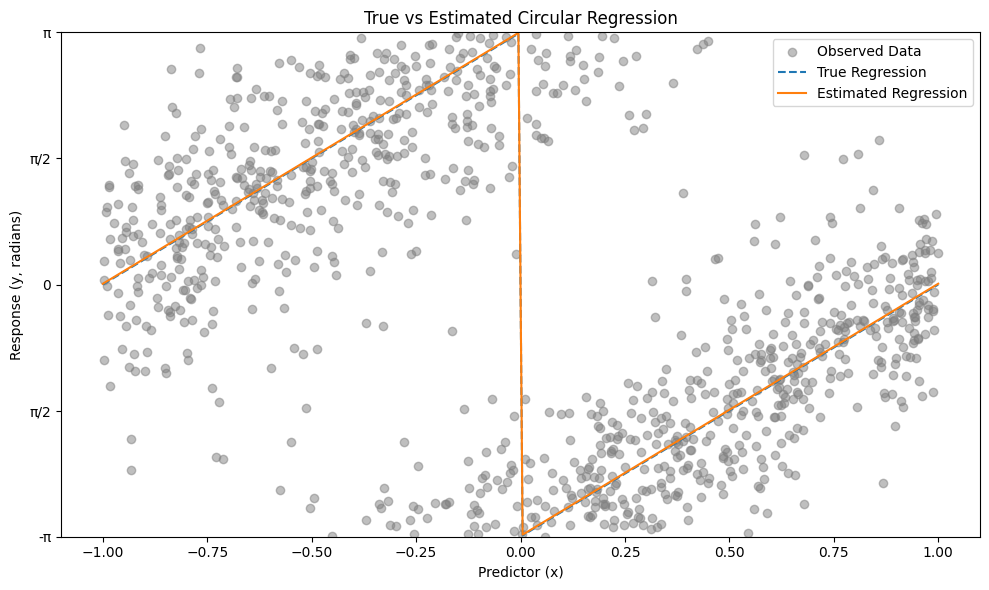

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from unwrap.link.numpy import shifted_modulo

# Extract the predictor variable and response variable
x = data['x']
y = data['y']

# Generate x values for plotting lines
x_vals = np.linspace(-1, 1, 200)

# True parameters
true_intercept = np.pi
true_slope = np.pi

# True regression line (circular)
true_mu = shifted_modulo(true_intercept + true_slope * x_vals)

# Extract posterior estimates (mean of posterior distributions)
mu_intercept_est = az.summary(idata, var_names=['Intercept'], circ_var_names=["Intercept"])['mean'].values[0]
mu_slope_est = az.summary(idata, var_names=['x'])['mean'].values[0]

# Estimated regression line (circular)
est_mu = shifted_modulo(mu_intercept_est + mu_slope_est * x_vals)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot of observed data
ax.scatter(x, y, color='gray', alpha=0.5, label='Observed Data')

# Plot true regression line
ax.plot(x_vals, true_mu, label='True Regression', linestyle='--')

# Plot estimated regression line
ax.plot(x_vals, est_mu, label='Estimated Regression', linestyle='-')

# Customizing plot
ax.set_xlabel('Predictor (x)')
ax.set_ylabel('Response (y, radians)')
ax.set_title('True vs Estimated Circular Regression')
ax.legend()

# Adjust y-axis to show circular range [0, 2*pi]
ax.set_ylim(-np.pi, np.pi)
ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_yticklabels(['-π', 'π/2', '0', 'π/2', 'π'])

plt.tight_layout()
plt.show()
